# Analyses on MITgcm filtered SSH 

In [1]:
import numpy as np 
import xarray as xr
import xrft 
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import powerspec as ps
import matplotlib.pyplot as plt
import matplotlib

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import pandas as pd

import gc 

import cmocean

from joblib import Parallel
from joblib import delayed as jb_delayed

#matplotlib.use('Agg')

## 1. - Data 

In [ ]:
ssh = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120501.nc")

In [ ]:
ssh.ssh_bar[14].plot()

In [ ]:
ssh_bis = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120601.nc")

In [ ]:
ssh_bis.ssh_bar[14].plot()

In [ ]:
#ds_ssh_bar = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_bar/daily_files/MITgcm_bar_201206*.nc")
#ds_ssh_bar = xr.open_mfdataset(["/bettik/bellemva/MITgcm/MITgcm_bar/daily_files/MITgcm_bar_20120601.nc",
#                                "/bettik/bellemva/MITgcm/MITgcm_bar/daily_files/MITgcm_bar_20120602.nc",
#                                "/bettik/bellemva/MITgcm/MITgcm_bar/daily_files/MITgcm_bar_20120603.nc"])
ds_ssh_bar = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_bar/daily_files/MITgcm_bar_20120601.nc")
ds_ssh_bar = ds_ssh_bar.sel(longitude = slice(180,235))
#ds_ssh_bar = ds_ssh_bar.fillna(0)
ssh_bar = ds_ssh_bar.ssh_bar

In [ ]:
plt.pcolormesh(ssh_bar.longitude.values,ssh_bar.latitude.values,ssh_bar.values,cmap="RdBu",vmin=-0.2,vmax=0.2)
#plt.xlim(180,200)
#plt.ylim(10,20)


In [ ]:
#Interpolate and replace nans 
kernel = Gaussian2DKernel(x_stddev=4)
ssh_bar_nonans=np.empty(ssh_bar.values.shape)
for i in range (23):
    ssh_bar_nonans[i,:,:] = interpolate_replace_nans(ssh_bar[i].values, kernel)
    print(i)


In [ ]:
ssh_bar_nonans = xr.DataArray(ssh_bar_nonans,dims=['time','latitude','longitude'])
ssh_bar_nonans

In [ ]:
psd_bar = xrft.isotropic_power_spectrum(ssh_bar_nonans,dim = ["longitude","latitude"],detrend='constant').compute()

In [ ]:
psd_bar

In [ ]:
psd_bar = psd_bar.mean(dim=["time"])

In [ ]:
plt.plot(111.2*np.ones(psd_bar.freq_r.values.shape)/psd_bar.freq_r.values,psd_bar.values)
plt.xlim(10000,150)
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=200,color="red")


## 2. - Pictures 

In [4]:
import cmocean

In [7]:
def plot_var(array,longitude,latitude,time,title,vmin,vmax,cmap,save_fig = False) : 

    fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

    ax.set_extent([-180, -115,10, 45],crs=ccrs.PlateCarree())
    map_ssh = ax.pcolormesh(longitude,
                latitude,
                array,
                vmin=vmin,vmax =vmax,
                cmap=cmap,
                )
    
    ax.text(s=str(time.astype('datetime64[h]')),x=-179,y=43,color="white")

    ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
    ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
    ax.coastlines(lw=0.5)
    ax.set_aspect("equal")
    ax.set_title(title)

    gridlines = ax.gridlines(
        alpha=0.3,
        color="white",
        draw_labels=True,
        xlocs=np.arange(-180,-115,10),
        ylocs=np.arange(10,45,5),
        # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
    )
    gridlines.right_labels = False
    gridlines.top_labels  = False
    gridlines.xlabel_style = {'size': 11}
    gridlines.ylabel_style = {'size': 11}
    ax.set_aspect("equal")

    cbar = fig.colorbar(mappable = map_ssh,shrink = 0.95,ax = ax)
    cbar.set_label("SSH [m]")

    if save_fig: 
        plt.savefig("./frames/"+name_var+"/"+name_var+"_"+pd.to_datetime(ds.time[time_index].values).strftime("%y%m%dT%H")+".png")

    else : 
        plt.show() 

In [8]:
ds=xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120601.nc").ssh_cor.load()
#plot_var(name_var="ssh_cor",ds = ds,title = "Internal Tide",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = 1,save_fig = False)

<xarray.DataArray 'ssh_cor' ()>
array(0.63338162)

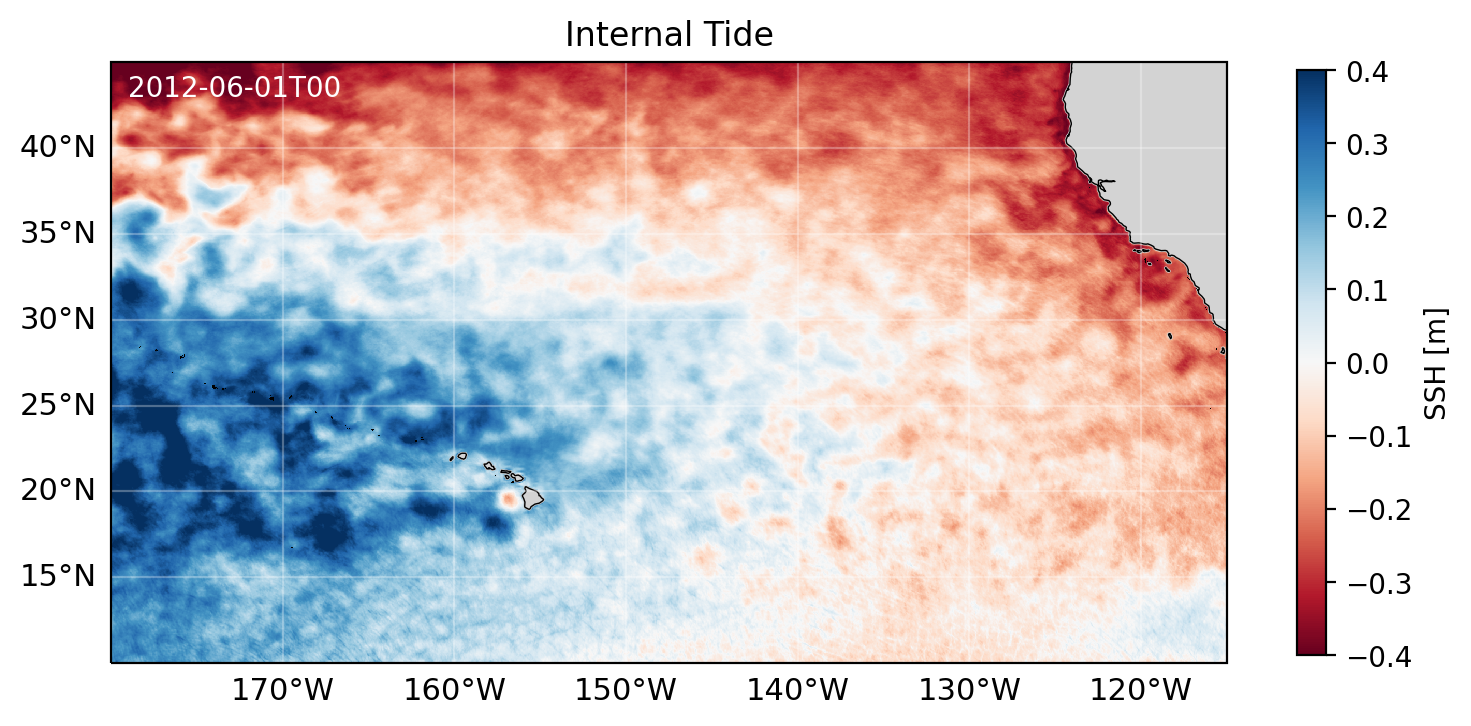

In [20]:
plot_var(array=ds.values[23,:,:]-ds.mean(dim=["time","longitude","latitude"]).values,longitude=ds.longitude,latitude=ds.latitude,time=ds.time[0].values,title = "Internal Tide",vmin=-0.4,vmax=0.4,cmap="RdBu",save_fig = False)

In [ ]:
# Regular for loop #

matplotlib.use('Agg')

for d in np.arange(np.datetime64("2012-06-01"),np.datetime64("2012-06-15")) : 
    ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"+d.astype('str').replace("-","")+".nc")
    ds = ds.load()
    for i in range (24): 
        #plot_var(name_var="ssh_cor",ds = ds,title = "Modelled Sea Surface Height (SSH)",vmin=-1.2,vmax=1.2,cmap=cmocean.cm.curl, time_index = i,save_fig = True)
        #plot_var(name_var="ssh_bm",ds = ds,title = "Balanced Motion",vmin=-1.2,vmax=1.2,cmap=cmocean.cm.curl, time_index = i,save_fig = True) 
        #plot_var(name_var="ssh_igw",ds = ds,title = "Internal Tides",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = i,save_fig = True) 
        plot_var(name_var="ssh_it",ds = ds,title = "Internal Tide",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = i,save_fig = False)
        print(d,i)
    del ds 
    gc.collect()

In [ ]:
d = np.datetime64("2012-06-07")
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"+d.astype('str').replace("-","")+".nc")
ds = ds.load()
for i in range (2,24): 
    #plot_var(name_var="ssh_cor",ds = ds,title = "Modelled Sea Surface Height (SSH)",vmin=-1.2,vmax=1.2,cmap=cmocean.cm.curl, time_index = i,save_fig = True)
    #plot_var(name_var="ssh_bm",ds = ds,title = "Balanced Motion",vmin=-1.2,vmax=1.2,cmap=cmocean.cm.curl, time_index = i,save_fig = True) 
    #plot_var(name_var="ssh_igw",ds = ds,title = "Internal Tides",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = i,save_fig = True) 
    plot_var(name_var="ssh_it",ds = ds,title = "Internal Tide",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = i,save_fig = True)
    print(d,i)

In [ ]:
def plot_one_day(date):
    ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"+date.astype('str').replace("-","")+".nc")
    ds = ds.load()
    for i in range (24): 
        #plot_var(name_var="ssh_cor",ds = ds,title = "Modelled Sea Surface Height (SSH)",vmin=-1.2,vmax=1.2,cmap=cmocean.cm.curl, time_index = i,save_fig = True)
        #plot_var(name_var="ssh_bm",ds = ds,title = "Balanced Motion",vmin=-1.2,vmax=1.2,cmap=cmocean.cm.curl, time_index = i,save_fig = True) 
        #plot_var(name_var="ssh_igw",ds = ds,title = "Internal Tides",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = i,save_fig = True) 
        plot_var(name_var="ssh_it",ds = ds,title = "Internal Tide",vmin=-0.1,vmax=0.1,cmap=cmocean.cm.curl, time_index = i,save_fig = True)
        #print(d,i)
    del ds 
    gc.collect()

In [ ]:
array_date = np.arange(np.datetime64("2012-06-01"),np.datetime64("2012-06-15")) 

res = Parallel(n_jobs=14,backend='multiprocessing')(jb_delayed(plot_one_day)(array_date[i]) for i in range (14))

In [ ]:
plot_one_day(array_date[2])